In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.TPUStrategy(tpu)
  print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')
except ValueError:
  print("WARNING: Not connected to a TPU runtime; WIll try GPU")
  if tf.config.list_physical_devices('GPU'):
    tpu_strategy = tf.distribute.MirroredStrategy()
    print(f'Running on {len(tf.config.list_physical_devices("GPU"))} GPUs')
  else:
    print('WARNING: Not connected to TPU or GPU runtime; Will use CPU context')
    tpu_strategy = tf.distribute.get_strategy()

Tensorflow version 2.15.0
Running on a TPU w/8 cores


In [3]:
image_dimensions = (512, 512)
with_augemtation = False
batch_size = 16

In [4]:
training_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/lion_no_lion/set 2',
    batch_size=batch_size,
    validation_split=0.2,
    subset='both',
    seed=42,
    shuffle=True,
    image_size=image_dimensions,
    color_mode='rgb',
)

Found 1294 files belonging to 2 classes.
Using 1036 files for training.
Using 258 files for validation.


In [7]:
with tpu_strategy.scope():
  base_model = tf.keras.applications.Xception(
      weights=None,
      include_top=False,
      input_shape=(*image_dimensions, 3)
  )

  print(f'Number of layers in the base model: {len(base_model.layers)}')
  print(f'Shape of the output layer:          {base_model.layers[-1].output_shape}')

  base_model.trainable = True

  input_layers = []
  if with_augemtation:
    input_layers = [
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomRotation(0.01),
        tf.keras.layers.RandomZoom(0.05),
        tf.keras.layers.RandomBrightness((-0.1, 0.1)),
        tf.keras.layers.RandomContrast(0.1),
        # tf.keras.layers.RandomCrop(200, 200),
        # tf.keras.layers.Rescaling(1./255),
    ]

  model = tf.keras.Sequential([
      *input_layers,
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.build(input_shape=(None, *image_dimensions, 3))

  model.compile(
      optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),
      loss='binary_crossentropy',
      metrics=['accuracy'],
  )

  model.summary()

Number of layers in the base model: 132
Shape of the output layer:          (None, 16, 16, 2048)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 16, 16, 2048)      20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20863529 (79.59 MB)
Trainable params: 20809001 (79.38 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [8]:
history = model.fit(
    training_dataset,
    epochs=500,
    validation_data=validation_dataset,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs')
    ]
)

Epoch 1/500
65/65 [==============================] - 68s 285ms/step - loss: 0.6693 - accuracy: 0.6197 - val_loss: nan - val_accuracy: 0.4884
Epoch 2/500
65/65 [==============================] - 12s 171ms/step - loss: nan - accuracy: 0.5357 - val_loss: nan - val_accuracy: 0.4884
Epoch 3/500
65/65 [==============================] - 12s 181ms/step - loss: nan - accuracy: 0.5357 - val_loss: nan - val_accuracy: 0.4884
Epoch 4/500
65/65 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5357

KeyboardInterrupt: 

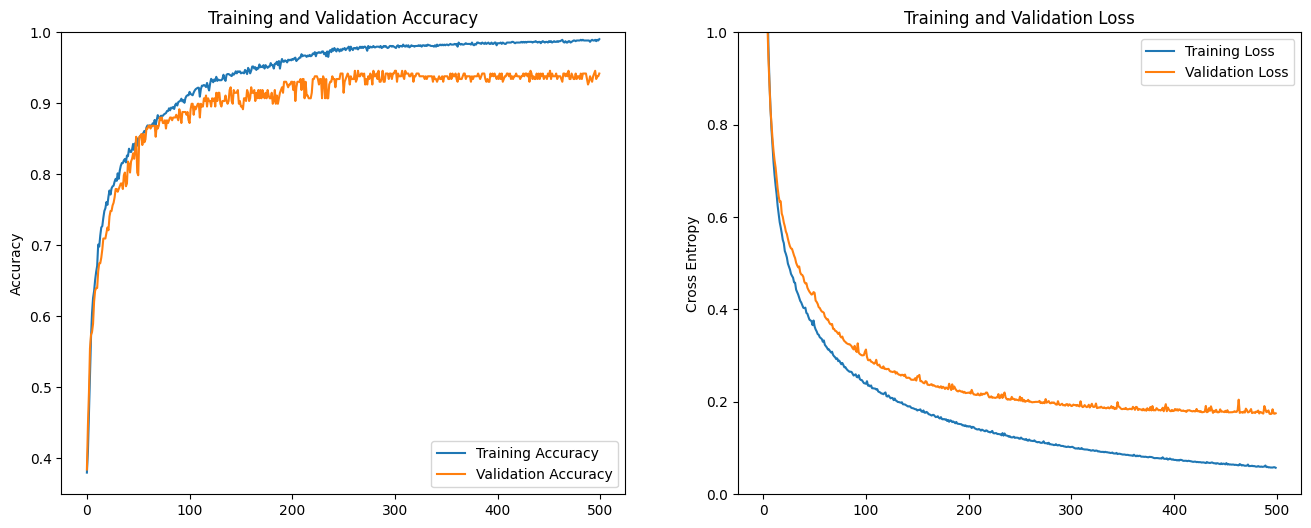

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.show()

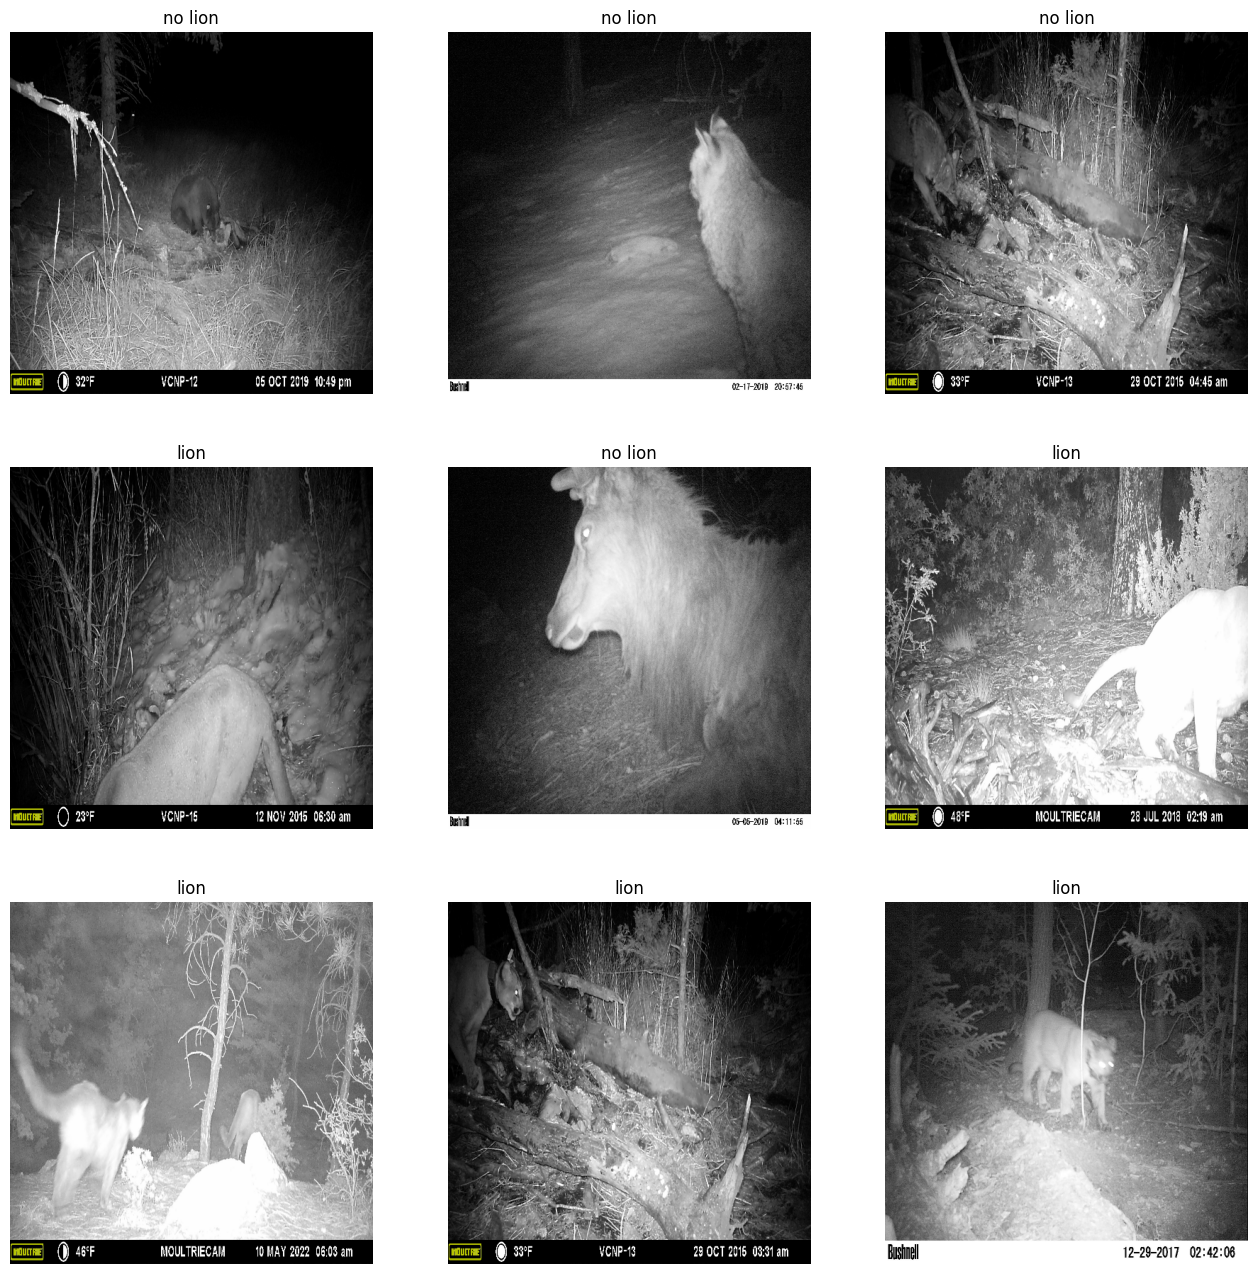

1/1 [==============================] - 9s 9s/step


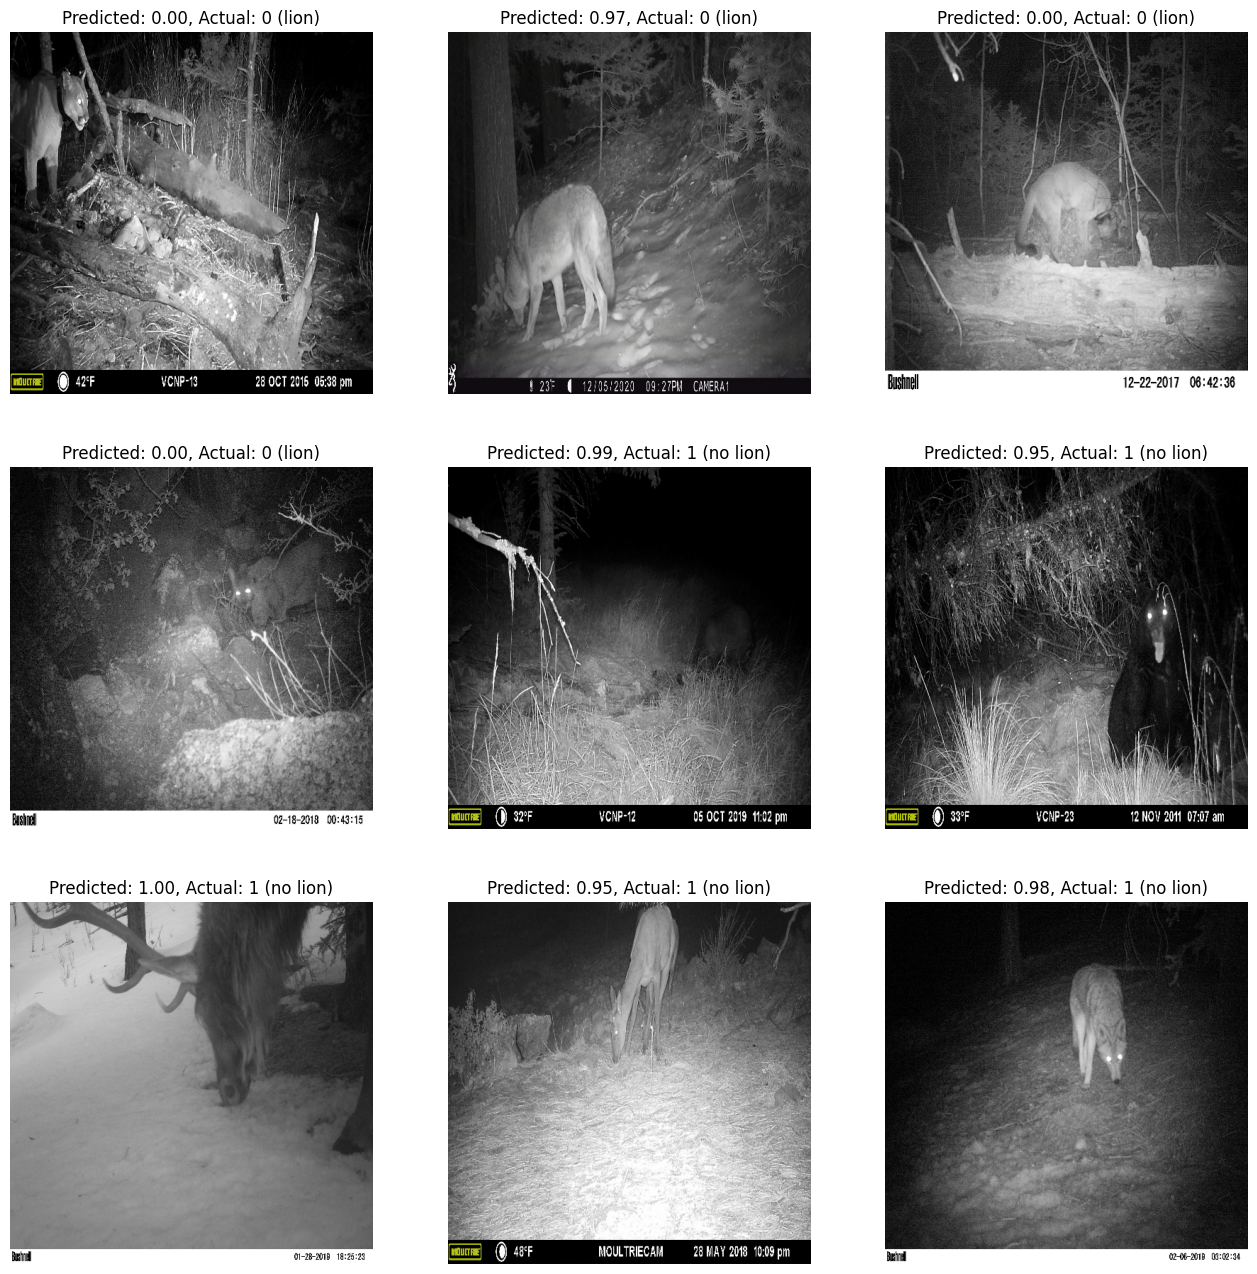

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(training_dataset))

plt.figure(figsize=(16, 16))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(f"{'lion' if labels[i] == 0 else 'no lion'}")
  plt.axis('off')

plt.show()

images, labels = next(iter(validation_dataset))

# Predict the labels for the images
predictions = model.predict(images)

# Plot the images and their predicted labels
plt.figure(figsize=(16, 16))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(f"Predicted: {predictions[i][0]:.2f}, Actual: {labels[i]} ({'lion' if labels[i] == 0 else 'no lion'})")
  plt.axis('off')

plt.show()

**Next Steps**:

- XCeption Model
  1. Try on bigger dataset (set 2)
  2. Try with preloaded weights and random weights
  3. Image resolution
  4. Augmentation
- Model from scratch; Convolutinonal Neural Network
  1. Image resolution
  2. Augmentation
- Compelling images of when the model succedes or fails

**Calculations**:

1. XCeption; imagenet; set 1; 224x224; no augmentation
1. XCeption; imagenet; set 1; 224x224; with augmentation
1. XCeption; imagenet; set 1; 512x512; no augmentation
1. XCeption; imagenet; set 1; 512x512; with augmentation
1. XCeption; imagenet; set 1; 1024s1024; no augmentation
1. XCeption; imagenet; set 1; 1024s1024; with augmentation
1. XCeption; imagenet; set 2; 224x224; no augmentation
1. XCeption; imagenet; set 2; 224x224; with augmentation
1. XCeption; imagenet; set 2; 512x512; no augmentation
1. XCeption; imagenet; set 2; 512x512; with augmentation
1. XCeption; imagenet; set 2; 1024s1024; no augmentation
1. XCeption; imagenet; set 2; 1024s1024; with augmentation
1. XCeption; random; set 1; 224x224; no augmentation
1. XCeption; random; set 1; 224x224; with augmentation
1. XCeption; random; set 1; 512x512; no augmentation
1. XCeption; random; set 1; 512x512; with augmentation
1. XCeption; random; set 1; 1024s1024; no augmentation
1. XCeption; random; set 1; 1024s1024; with augmentation
1. XCeption; random; set 2; 224x224; no augmentation
1. XCeption; random; set 2; 224x224; with augmentation
1. XCeption; random; set 2; 512x512; no augmentation
1. XCeption; random; set 2; 512x512; with augmentation
1. XCeption; random; set 2; 1024s1024; no augmentation
1. XCeption; random; set 2; 1024s1024; with augmentation